In [ ]:
import numpy as np
import pandas as pd

import os
print(os.listdir("../input"))

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/working/')
    
print('After zip extraction:')
print(os.listdir("/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['__notebook__.ipynb', 'plates', '__MACOSX']


In [ ]:
data_root = '/working/plates/'
print(os.listdir(data_root))

['.DS_Store', 'train', 'test']


In [ ]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

#print(len(os.listdir(os.path.join(train_dir, 'cleaned'))), len(os.listdir(os.path.join(train_dir, 'dirty'))))

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    lst = os.listdir(source_dir)
    for i in range(len(lst)):
        if lst[len(lst)-1-i][-4:] != '.jpg':
            del lst[len(lst)-1-i]
    #print(lst)
    for i, file_name in enumerate(tqdm(lst)):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
        
#print(len(os.listdir(os.path.join(train_dir, 'cleaned'))), len(os.listdir(os.path.join(train_dir, 'dirty'))))
#print(len(os.listdir(val_dir)))

100%|██████████| 20/20 [00:00<00:00, 4870.58it/s]


In [ ]:
!ls train

cleaned  dirty


In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [ ]:
len(train_dataloader), len(train_dataset)

(4, 32)

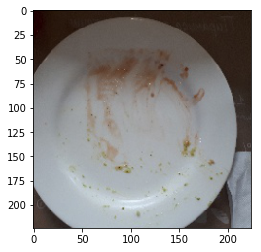

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

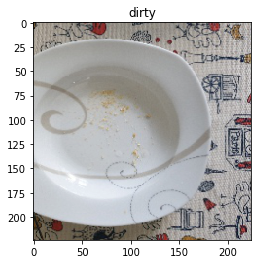

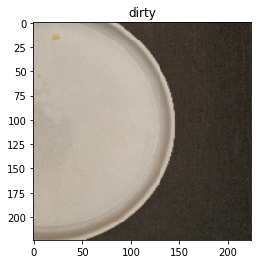

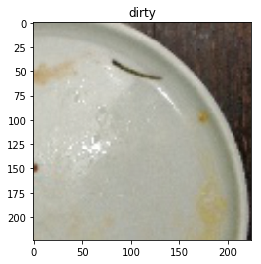

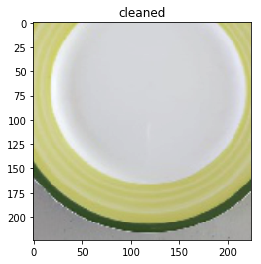

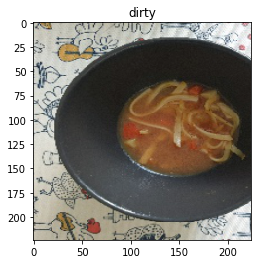

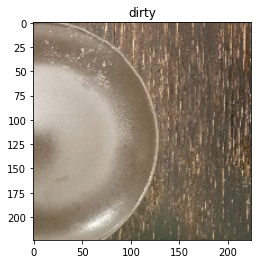

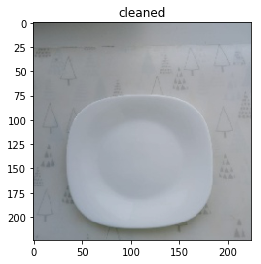

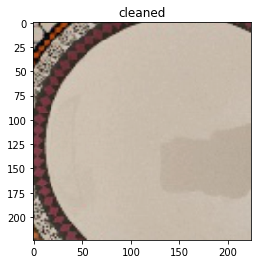

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [ ]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters(): # каждый параметр это слой
    param.requires_grad = False # не требуем вычисление градиента, чтобы не переобучать сеть, она заморожена

# меняем последний полносвязный слой, т.к. тот слой, что в resnet по умолчанию, классифицирует
# на 1000 классов, а у нас их всего 2
# model.fc.in_features - 512 классов
model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss() # на вход - активации нейронов, то, что до софтмакса
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)

# планировщик, уменьшающий шаг градиентного спуска в 1/gamma раз каждые step_size эпох
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 84191327.93it/s]


In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

train Loss: 0.8303 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

val Loss: 0.7446 Acc: 0.5000
Epoch 1/99:



100%|██████████| 4/4 [00:00<00:00,  8.96it/s]

train Loss: 0.7487 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

val Loss: 0.7900 Acc: 0.5000
Epoch 2/99:



100%|██████████| 4/4 [00:00<00:00,  9.03it/s]

train Loss: 0.6784 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

val Loss: 0.7230 Acc: 0.5000
Epoch 3/99:



100%|██████████| 4/4 [00:00<00:00,  9.08it/s]

train Loss: 0.5936 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

val Loss: 0.7395 Acc: 0.6250
Epoch 4/99:



100%|██████████| 4/4 [00:00<00:00,  9.07it/s]

train Loss: 0.5784 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

val Loss: 0.7060 Acc: 0.6250
Epoch 5/99:



100%|██████████| 4/4 [00:00<00:00,  9.37it/s]

train Loss: 0.5083 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

val Loss: 0.6738 Acc: 0.5000
Epoch 6/99:



100%|██████████| 4/4 [00:00<00:00,  9.52it/s]

train Loss: 0.4881 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

val Loss: 0.6759 Acc: 0.5000
Epoch 7/99:



100%|██████████| 4/4 [00:00<00:00,  9.48it/s]

train Loss: 0.4858 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

val Loss: 0.6856 Acc: 0.5000
Epoch 8/99:



100%|██████████| 4/4 [00:00<00:00,  9.67it/s]

train Loss: 0.4490 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

val Loss: 0.6883 Acc: 0.5000
Epoch 9/99:



100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

train Loss: 0.4884 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

val Loss: 0.6751 Acc: 0.5000
Epoch 10/99:



100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

train Loss: 0.4544 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

val Loss: 0.6661 Acc: 0.5000
Epoch 11/99:



100%|██████████| 4/4 [00:00<00:00,  9.19it/s]

train Loss: 0.4904 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

val Loss: 0.6721 Acc: 0.5000
Epoch 12/99:



100%|██████████| 4/4 [00:00<00:00,  9.54it/s]

train Loss: 0.4140 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

val Loss: 0.6662 Acc: 0.5000
Epoch 13/99:



100%|██████████| 4/4 [00:00<00:00,  9.25it/s]

train Loss: 0.4855 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

val Loss: 0.6613 Acc: 0.5000
Epoch 14/99:



100%|██████████| 4/4 [00:00<00:00,  9.24it/s]

train Loss: 0.5015 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

val Loss: 0.6395 Acc: 0.5000
Epoch 15/99:



100%|██████████| 4/4 [00:00<00:00,  9.35it/s]

train Loss: 0.5006 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

val Loss: 0.6440 Acc: 0.5000
Epoch 16/99:



100%|██████████| 4/4 [00:00<00:00,  9.06it/s]

train Loss: 0.5415 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.09it/s]

val Loss: 0.6551 Acc: 0.5000
Epoch 17/99:



100%|██████████| 4/4 [00:00<00:00,  6.37it/s]

train Loss: 0.4856 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

val Loss: 0.6515 Acc: 0.6250
Epoch 18/99:



100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


train Loss: 0.5067 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

val Loss: 0.6594 Acc: 0.5000
Epoch 19/99:



100%|██████████| 4/4 [00:00<00:00,  9.35it/s]

train Loss: 0.4433 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

val Loss: 0.6554 Acc: 0.5000
Epoch 20/99:



100%|██████████| 4/4 [00:00<00:00,  9.27it/s]

train Loss: 0.4556 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

val Loss: 0.6613 Acc: 0.5000
Epoch 21/99:



100%|██████████| 4/4 [00:00<00:00,  9.36it/s]

train Loss: 0.4876 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

val Loss: 0.6562 Acc: 0.5000
Epoch 22/99:



100%|██████████| 4/4 [00:00<00:00,  9.67it/s]

train Loss: 0.4694 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

val Loss: 0.6603 Acc: 0.5000
Epoch 23/99:



100%|██████████| 4/4 [00:00<00:00,  6.65it/s]

train Loss: 0.4437 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

val Loss: 0.6646 Acc: 0.5000
Epoch 24/99:



100%|██████████| 4/4 [00:00<00:00,  8.84it/s]

train Loss: 0.4832 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.09it/s]

val Loss: 0.6761 Acc: 0.5000
Epoch 25/99:



100%|██████████| 4/4 [00:00<00:00,  9.52it/s]

train Loss: 0.4696 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.09it/s]

val Loss: 0.6655 Acc: 0.5000
Epoch 26/99:



100%|██████████| 4/4 [00:00<00:00,  9.25it/s]

train Loss: 0.4711 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

val Loss: 0.6603 Acc: 0.5000
Epoch 27/99:



100%|██████████| 4/4 [00:00<00:00,  9.42it/s]

train Loss: 0.4175 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  5.09it/s]

val Loss: 0.6731 Acc: 0.5000
Epoch 28/99:



100%|██████████| 4/4 [00:00<00:00,  9.29it/s]

train Loss: 0.4331 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

val Loss: 0.6581 Acc: 0.5000
Epoch 29/99:



100%|██████████| 4/4 [00:00<00:00,  9.13it/s]

train Loss: 0.4976 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

val Loss: 0.6555 Acc: 0.5000
Epoch 30/99:



100%|██████████| 4/4 [00:00<00:00,  9.42it/s]

train Loss: 0.4376 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

val Loss: 0.6444 Acc: 0.5000
Epoch 31/99:



100%|██████████| 4/4 [00:00<00:00,  9.13it/s]

train Loss: 0.5375 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

val Loss: 0.6376 Acc: 0.5000
Epoch 32/99:



100%|██████████| 4/4 [00:00<00:00,  9.27it/s]

train Loss: 0.4226 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

val Loss: 0.6690 Acc: 0.5000
Epoch 33/99:



100%|██████████| 4/4 [00:00<00:00,  9.06it/s]

train Loss: 0.5113 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

val Loss: 0.6636 Acc: 0.5000
Epoch 34/99:



100%|██████████| 4/4 [00:00<00:00,  9.16it/s]

train Loss: 0.4669 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

val Loss: 0.6718 Acc: 0.5000
Epoch 35/99:



100%|██████████| 4/4 [00:00<00:00,  9.24it/s]

train Loss: 0.5050 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.11it/s]

val Loss: 0.6609 Acc: 0.5000
Epoch 36/99:



100%|██████████| 4/4 [00:00<00:00,  9.11it/s]

train Loss: 0.4685 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

val Loss: 0.6488 Acc: 0.5000
Epoch 37/99:



100%|██████████| 4/4 [00:00<00:00,  9.62it/s]

train Loss: 0.4550 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

val Loss: 0.6458 Acc: 0.5000
Epoch 38/99:



100%|██████████| 4/4 [00:00<00:00,  7.31it/s]

train Loss: 0.5117 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

val Loss: 0.6488 Acc: 0.5000
Epoch 39/99:



100%|██████████| 4/4 [00:00<00:00,  9.15it/s]

train Loss: 0.4448 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

val Loss: 0.6532 Acc: 0.5000
Epoch 40/99:



100%|██████████| 4/4 [00:00<00:00,  9.38it/s]

train Loss: 0.4572 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

val Loss: 0.6531 Acc: 0.5000
Epoch 41/99:



100%|██████████| 4/4 [00:00<00:00,  9.12it/s]

train Loss: 0.4434 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

val Loss: 0.6635 Acc: 0.5000
Epoch 42/99:



100%|██████████| 4/4 [00:00<00:00,  9.41it/s]

train Loss: 0.4705 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

val Loss: 0.6701 Acc: 0.5000
Epoch 43/99:



100%|██████████| 4/4 [00:00<00:00,  9.28it/s]

train Loss: 0.5012 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

val Loss: 0.6802 Acc: 0.5000
Epoch 44/99:



100%|██████████| 4/4 [00:00<00:00,  9.16it/s]

train Loss: 0.4568 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

val Loss: 0.6750 Acc: 0.5000
Epoch 45/99:



100%|██████████| 4/4 [00:00<00:00,  9.33it/s]

train Loss: 0.4346 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

val Loss: 0.6775 Acc: 0.5000
Epoch 46/99:



100%|██████████| 4/4 [00:00<00:00,  7.66it/s]

train Loss: 0.4098 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

val Loss: 0.6703 Acc: 0.5000
Epoch 47/99:



100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

train Loss: 0.4907 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

val Loss: 0.6751 Acc: 0.5000
Epoch 48/99:



100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

train Loss: 0.4933 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

val Loss: 0.6809 Acc: 0.5000
Epoch 49/99:



100%|██████████| 4/4 [00:00<00:00,  5.83it/s]

train Loss: 0.5105 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

val Loss: 0.6705 Acc: 0.5000
Epoch 50/99:



100%|██████████| 4/4 [00:00<00:00,  9.26it/s]

train Loss: 0.4454 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

val Loss: 0.6651 Acc: 0.5000
Epoch 51/99:



100%|██████████| 4/4 [00:00<00:00,  3.58it/s]

train Loss: 0.4747 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

val Loss: 0.6679 Acc: 0.5000
Epoch 52/99:



100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

train Loss: 0.5155 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

val Loss: 0.6702 Acc: 0.5000
Epoch 53/99:



100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

train Loss: 0.4698 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

val Loss: 0.6740 Acc: 0.5000
Epoch 54/99:



100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

train Loss: 0.4823 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

val Loss: 0.6710 Acc: 0.5000
Epoch 55/99:



100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

train Loss: 0.4323 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

val Loss: 0.6696 Acc: 0.5000
Epoch 56/99:



100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

train Loss: 0.4655 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

val Loss: 0.6640 Acc: 0.5000
Epoch 57/99:



100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

train Loss: 0.4880 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

val Loss: 0.6739 Acc: 0.5000
Epoch 58/99:



100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

train Loss: 0.4652 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.6801 Acc: 0.5000
Epoch 59/99:



100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

train Loss: 0.5014 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

val Loss: 0.6645 Acc: 0.5000
Epoch 60/99:



100%|██████████| 4/4 [00:00<00:00,  4.44it/s]

train Loss: 0.4573 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

val Loss: 0.6569 Acc: 0.5000
Epoch 61/99:



100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

train Loss: 0.3871 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.6522 Acc: 0.5000
Epoch 62/99:



100%|██████████| 4/4 [00:00<00:00,  2.61it/s]

train Loss: 0.4841 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.6596 Acc: 0.5000
Epoch 63/99:



100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

train Loss: 0.4399 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

val Loss: 0.6646 Acc: 0.5000
Epoch 64/99:



100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

train Loss: 0.4472 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

val Loss: 0.6546 Acc: 0.5000
Epoch 65/99:



100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

train Loss: 0.4818 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

val Loss: 0.6563 Acc: 0.5000
Epoch 66/99:



100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

train Loss: 0.5466 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

val Loss: 0.6628 Acc: 0.5000
Epoch 67/99:



100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

train Loss: 0.4623 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

val Loss: 0.6750 Acc: 0.5000
Epoch 68/99:



100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

train Loss: 0.4613 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

val Loss: 0.6712 Acc: 0.5000
Epoch 69/99:



100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

train Loss: 0.5175 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

val Loss: 0.6667 Acc: 0.5000
Epoch 70/99:



100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

train Loss: 0.4240 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

val Loss: 0.6647 Acc: 0.5000
Epoch 71/99:



100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

train Loss: 0.4446 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

val Loss: 0.6670 Acc: 0.5000
Epoch 72/99:



100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

train Loss: 0.4678 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

val Loss: 0.6572 Acc: 0.5000
Epoch 73/99:



100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

train Loss: 0.4731 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

val Loss: 0.6661 Acc: 0.5000
Epoch 74/99:



100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

train Loss: 0.4236 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

val Loss: 0.6667 Acc: 0.5000
Epoch 75/99:



100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

train Loss: 0.4473 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

val Loss: 0.6644 Acc: 0.5000
Epoch 76/99:



100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

train Loss: 0.4935 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

val Loss: 0.6600 Acc: 0.5000
Epoch 77/99:



100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

train Loss: 0.4398 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

val Loss: 0.6556 Acc: 0.5000
Epoch 78/99:



100%|██████████| 4/4 [00:01<00:00,  1.35it/s]

train Loss: 0.4423 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

val Loss: 0.6536 Acc: 0.5000
Epoch 79/99:



100%|██████████| 4/4 [00:00<00:00,  8.78it/s]

train Loss: 0.4708 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

val Loss: 0.6612 Acc: 0.5000
Epoch 80/99:



100%|██████████| 4/4 [00:00<00:00,  8.81it/s]

train Loss: 0.4563 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

val Loss: 0.6654 Acc: 0.5000
Epoch 81/99:



100%|██████████| 4/4 [00:00<00:00,  8.82it/s]

train Loss: 0.4985 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

val Loss: 0.6628 Acc: 0.5000
Epoch 82/99:



100%|██████████| 4/4 [00:00<00:00,  8.71it/s]

train Loss: 0.4983 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

val Loss: 0.6634 Acc: 0.5000
Epoch 83/99:



100%|██████████| 4/4 [00:00<00:00,  8.77it/s]

train Loss: 0.4546 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

val Loss: 0.6680 Acc: 0.5000
Epoch 84/99:



100%|██████████| 4/4 [00:00<00:00,  8.78it/s]

train Loss: 0.4753 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

val Loss: 0.6677 Acc: 0.5000
Epoch 85/99:



100%|██████████| 4/4 [00:00<00:00,  8.57it/s]

train Loss: 0.4614 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

val Loss: 0.6775 Acc: 0.5000
Epoch 86/99:



100%|██████████| 4/4 [00:00<00:00,  8.91it/s]

train Loss: 0.4797 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

val Loss: 0.6685 Acc: 0.5000
Epoch 87/99:



100%|██████████| 4/4 [00:00<00:00,  8.60it/s]

train Loss: 0.4079 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

val Loss: 0.6732 Acc: 0.5000
Epoch 88/99:



100%|██████████| 4/4 [00:00<00:00,  8.85it/s]

train Loss: 0.4909 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

val Loss: 0.6589 Acc: 0.5000
Epoch 89/99:



100%|██████████| 4/4 [00:00<00:00,  8.85it/s]

train Loss: 0.5539 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

val Loss: 0.6510 Acc: 0.5000
Epoch 90/99:



100%|██████████| 4/4 [00:00<00:00,  8.31it/s]

train Loss: 0.4364 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.6601 Acc: 0.5000
Epoch 91/99:



100%|██████████| 4/4 [00:00<00:00,  7.73it/s]

train Loss: 0.5149 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

val Loss: 0.6733 Acc: 0.5000
Epoch 92/99:



100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

train Loss: 0.4419 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

val Loss: 0.6738 Acc: 0.5000
Epoch 93/99:



100%|██████████| 4/4 [00:00<00:00,  8.63it/s]

train Loss: 0.3947 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

val Loss: 0.6702 Acc: 0.5000
Epoch 94/99:



100%|██████████| 4/4 [00:00<00:00,  8.79it/s]

train Loss: 0.4952 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

val Loss: 0.6654 Acc: 0.5000
Epoch 95/99:



100%|██████████| 4/4 [00:00<00:00,  8.91it/s]

train Loss: 0.4986 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

val Loss: 0.6559 Acc: 0.5000
Epoch 96/99:



100%|██████████| 4/4 [00:00<00:00,  8.76it/s]

train Loss: 0.5103 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

val Loss: 0.6452 Acc: 0.5000
Epoch 97/99:



100%|██████████| 4/4 [00:00<00:00,  9.05it/s]

train Loss: 0.4674 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

val Loss: 0.6504 Acc: 0.5000
Epoch 98/99:



100%|██████████| 4/4 [00:00<00:00,  8.84it/s]

train Loss: 0.4847 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

val Loss: 0.6660 Acc: 0.5000
Epoch 99/99:



100%|██████████| 4/4 [00:00<00:00,  8.96it/s]

train Loss: 0.4470 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

val Loss: 0.6611 Acc: 0.5000


In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:04<00:00, 18.34it/s]


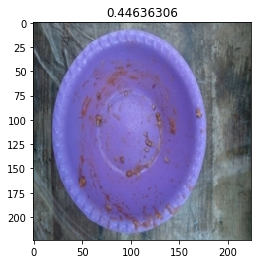

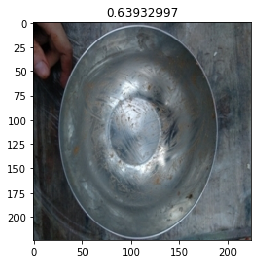

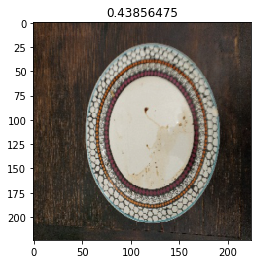

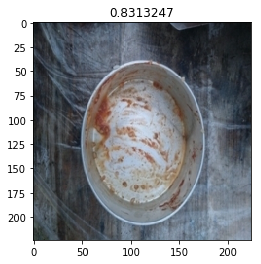

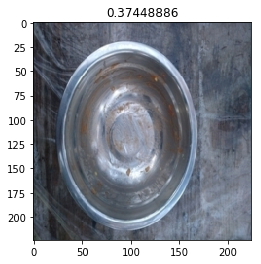

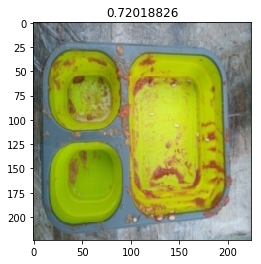

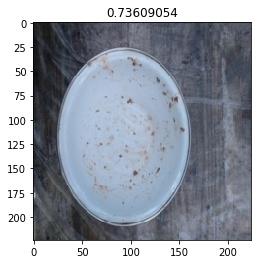

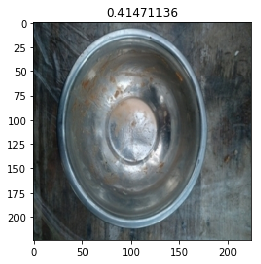

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,cleaned
0001,dirty
0002,cleaned
0003,dirty
0004,cleaned
0005,dirty


In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train val test